In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.4 is required in this notebook
# Earlier 2.x versions will mostly work the same, but with a few bugs
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.4"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 张量操作

### 张量

使用`tf.constant`创建常数张量，该类型张量的元素无法更改  
通常数学操作，如使用`tf.add`与`tf.math.add`指向的是同一个函数，这是为了简化代码，但是也有不一样的。如对数只能写`tf.math.log`  
通常tf的张量运算函数名称与numpy的是一样的，但也有不一样的，比如`np.mean`对应的是`tf.reduce_mean`

In [2]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]]) # matrix
tf.constant(42) # scalar

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [3]:
t.shape

TensorShape([2, 3])

In [4]:
t.dtype

tf.float32

### 张量索引

tf中张量的索引方式与在numpy中是十分相似的

In [5]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [6]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

In [7]:
t[:, 1]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 5.], dtype=float32)>

### 张量操作

In [8]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [9]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [10]:
# 矩阵乘法
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

### 使用`keras.backend`

keras.backend中也有像tf的诸如square()、exp()的函数，但是如果在tf.keras中使用这些keras的函数，那么其实还是会指向tf的函数

In [11]:
# 可见使用tf.keras.backend的运算函数其实还是tf的
from tensorflow import keras
K = keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

### 导入\导出为Numpy数组

<b><font color=red>注意:</font></b> numpy中的数组默认使用的64位精度，但是tf的张量默认使用32位精度。  
这是因为32位精度在神经网络训练中就已经绰绰有余了，而且还可以减少使用的内存，保障运行速度

In [12]:
a = np.array([2., 4., 5.])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [13]:
# 张量转换成numpy数组
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [14]:
# tf函数可以处理numpy数组
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [15]:
# numpy函数可以处理tf张量
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

### 类型转换

在tf中，不会自动转换张量类型，有点像静态语言  
比如不能把浮点张量与整数张量相加，甚至不能相加32位和64位浮点数  
所以如果张量要与numpy数组进行运算，记得确保位数一致

In [16]:
# 整数与浮点数张量无法运算
try:
    tf.constant(2.0) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2]


In [17]:
# 32位浮点数与64位浮点数无法运算
try:
    tf.constant(2.0) + tf.constant(40., dtype=tf.float64)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2]


In [18]:
# 如果需要类型转换，可以使用tf.cast()
t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

### 字符串张量

表示字节字符串，而不是Python的Unicode字符串  
tf.strings是原子级的，所以不显示长度，但若将其用Unicode代码表示，就可以显示长度了

In [19]:
# 字节字符串
tf.constant("hello world")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world'>

In [20]:
# 基于UTF-8代码保存字符串
tf.constant("café")

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [21]:
# 基于Ucicode代码保存字符串，可以在shape属性中显示字符串长度
u = tf.constant([ord(c) for c in "café"])
u

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233])>

In [22]:
# 使用tf.string对字符串进行编码，将Unicode字符串转换为UTF-8编码
b = tf.strings.unicode_encode(u, "UTF-8")
# 基于UTF8字符显示字符串长度
tf.strings.length(b, unit="UTF8_CHAR")

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [23]:
tf.strings.unicode_decode(b, "UTF-8")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233])>

### 字符串数组

In [24]:
p = tf.constant(["Café", "Coffee", "caffè", "咖啡"])

In [25]:
tf.strings.length(p, unit="UTF8_CHAR")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([4, 6, 5, 2])>

In [26]:
r = tf.strings.unicode_decode(p, "UTF8")
r

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101],
 [99, 97, 102, 102, 232], [21654, 21857]]>

In [27]:
print(r)

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101],
 [99, 97, 102, 102, 232], [21654, 21857]]>


### 不规则张量（Ragged tensors）

表示张量列表的静态列表，大小不可变，其中每个向量都有相同的形状和数据类型  
tf.ragged包含不规则张量的操作

In [28]:
r.to_tensor()

<tf.Tensor: shape=(4, 6), dtype=int32, numpy=
array([[   67,    97,   102,   233,     0,     0],
       [   67,   111,   102,   102,   101,   101],
       [   99,    97,   102,   102,   232,     0],
       [21654, 21857,     0,     0,     0,     0]])>

In [29]:
# 以行的形式加入三行，长度不够的地方用0填充
r2 = tf.ragged.constant([[65, 66], [], [67]])
tf.concat([r, r2], axis=0).to_tensor()

<tf.Tensor: shape=(7, 6), dtype=int32, numpy=
array([[   67,    97,   102,   233,     0,     0],
       [   67,   111,   102,   102,   101,   101],
       [   99,    97,   102,   102,   232,     0],
       [21654, 21857,     0,     0,     0,     0],
       [   65,    66,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0],
       [   67,     0,     0,     0,     0,     0]])>

In [30]:
# 以列的形式填充3列，优先填充目标行长度不够的位置（被0填充的位置），可以增加新的列
r3 = tf.ragged.constant([[68, 69, 70], [71], [], [72, 73]])
tf.concat([r, r3], axis=1).to_tensor()

<tf.Tensor: shape=(4, 7), dtype=int32, numpy=
array([[   67,    97,   102,   233,    68,    69,    70],
       [   67,   111,   102,   102,   101,   101,    71],
       [   99,    97,   102,   102,   232,     0,     0],
       [21654, 21857,    72,    73,     0,     0,     0]])>

In [31]:
# 使用UTF-8编码
tf.strings.unicode_encode(r3, "UTF-8")

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'DEF', b'G', b'', b'HI'], dtype=object)>

### 稀疏张量

In [32]:
s = tf.SparseTensor(indices=[[0, 1], [1, 0], [2, 3]], # 非零值的位置
                    values=[1., 2., 3.], # 菲零值
                    dense_shape=[3, 4]) # 形状

In [33]:
print(s)

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [34]:
tf.sparse.to_dense(s)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [2., 0., 0., 0.],
       [0., 0., 0., 3.]], dtype=float32)>

In [35]:
# 稀疏矩阵支持乘除法
s2 = s * 2.0

In [36]:
# 稀疏矩阵不支持加减操作
try:
    s3 = s + 1.
except TypeError as ex:
    print(ex)

unsupported operand type(s) for +: 'SparseTensor' and 'float'


In [37]:
# 除非先将稀疏矩阵转换成dense矩阵
s4 = tf.sparse.to_dense(s) + 1.

In [38]:
# 矩阵乘法需调用sparse_dense_matmul方法
s4 = tf.constant([[10., 20.], [30., 40.], [50., 60.], [70., 80.]])
tf.sparse.sparse_dense_matmul(s, s4)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 30.,  40.],
       [ 20.,  40.],
       [210., 240.]], dtype=float32)>

In [39]:
# 在构造稀疏矩阵的时候，最好是按照行和列的顺序定义各个位置的元素，不要像下面这样
s5 = tf.SparseTensor(indices=[[0, 2], [0, 1]],
                     values=[1., 2.],
                     dense_shape=[3, 4])
print(s5)

SparseTensor(indices=tf.Tensor(
[[0 2]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([1. 2.], shape=(2,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [40]:
# 否则就没办法转换成dense矩阵了
try:
    tf.sparse.to_dense(s5)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

indices[1] is out of order. Many sparse ops require sorted indices.
  Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SparseToDense]


In [41]:
# 但是可以使用reorder方法来重新排序各元素的定义的顺序
s6 = tf.sparse.reorder(s5)
tf.sparse.to_dense(s6)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 2., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

### 集合

就像Python中集合那样，可以合并重复值

In [42]:
set1 = tf.constant([[2, 3, 5, 7], [7, 9, 0, 0]])
set2 = tf.constant([[4, 5, 6], [9, 10, 0]])
# 得到最后
tf.sparse.to_dense(tf.sets.union(set1, set2))

<tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 2,  3,  4,  5,  6,  7],
       [ 0,  7,  9, 10,  0,  0]])>

### 变量

前面的张量都是不能修改的，这就意味着其不能作为反向传播权重的载体  
变量类型的张量可以担负这个任务，但是一般不用使用者亲自修改

In [43]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])

In [44]:
# 使用assign方法对张量进行修改
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [45]:
# 定点分配值
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [46]:
# 在切片中分配数值
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [47]:
# 不能直接指定
try:
    v[1] = [7., 8., 9.]
except TypeError as ex:
    print(ex)

'ResourceVariable' object does not support item assignment


In [48]:
# 用scatter_nd_update方法也可以修改值
v.scatter_nd_update(indices=[[0, 0], [1, 2]],
                    updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

In [49]:
# 再或者向scatter_update方法中传入IndexedSlices实例来修改
sparse_delta = tf.IndexedSlices(values=[[1., 2., 3.], [4., 5., 6.]],
                                indices=[1, 0])
v.scatter_update(sparse_delta)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[4., 5., 6.],
       [1., 2., 3.]], dtype=float32)>

### 张量数组

有点像动态数组，可以后续添加新的行

In [50]:
array = tf.TensorArray(dtype=tf.float32, size=3)
array = array.write(0, tf.constant([1., 2.]))
array = array.write(1, tf.constant([3., 10.]))
array = array.write(2, tf.constant([5., 7.]))

In [51]:
# 从数组中取出第二行
array.read(1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 3., 10.], dtype=float32)>

In [52]:
# 第二行元素被取走，用0填充原来的位置
# 以栈的形式展示数组
array.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [0., 0.],
       [5., 7.]], dtype=float32)>

In [53]:
mean, variance = tf.nn.moments(array.stack(), axes=0)
mean

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 3.], dtype=float32)>

In [54]:
variance

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.6666665, 8.666667 ], dtype=float32)>

## 自定义模型和训练算法

### 自定义损失函数

以一个回归神经网络为例，数据的话还是拿加利福利亚房产数据  
首先要强调的是：如果想要自定义的损失函数可以从tensorflow的图形功能中受益，就要在函数中尽可能使用向量化实现

In [55]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [56]:
# 自定义一个损失函数：huber损失函数，虽然keras.loss中有它的实现。但是这里非要自己做
# 注意这里的向量要尽可能用tf的张量函数来表示
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

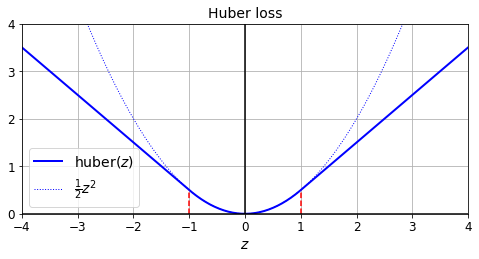

In [57]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [58]:
input_shape = X_train.shape[1:]

# 来建立一个非常简单的网络
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

# 这里输入自定义的huber损失函数
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 3ms/step - loss: 0.6235 - mae: 0.9953 - val_loss: 0.2862 - val_mae: 0.5866
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2197 - mae: 0.5177 - val_loss: 0.2382 - val_mae: 0.5281


### 保存\加载使用了自定义对象的模型

在脚本中使用自定义的损失函数很方便，但是要是加载一个使用了自定义函数的模型就麻烦了，因为在保存模型的时候是不会把自定义的对象也给保存了的

In [59]:
model.save("my_model_with_a_custom_loss.h5")

In [60]:
# 模型在保存的时候会将自定义的对象名称当做一个字典的键保存起来
# 在加载的时候只需要向字典中对应的键传递相应的对象就行了
model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})

In [61]:
# 可见此时网络是可以正常训练的
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2054 - mae: 0.4982 - val_loss: 0.2209 - val_mae: 0.5050
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.1999 - mae: 0.4900 - val_loss: 0.2127 - val_mae: 0.4986


In [62]:
# 如果想要改变huber函数中的误差的阈值，可以这么写
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [63]:
# 然后被这样调用
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.2226 - mae: 0.4892 - val_loss: 0.2539 - val_mae: 0.4907
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2184 - mae: 0.4844 - val_loss: 0.2372 - val_mae: 0.4879


In [64]:
# 但是有一个问题，那就是在保存模型的时候不会保存自定义的阈值
model.save("my_model_with_a_custom_loss_threshold_2.h5")

# 并且在加载的时候键仍是huber_fn，需要手动指定阈值
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

In [65]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2147 - mae: 0.4800 - val_loss: 0.2133 - val_mae: 0.4654
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2119 - mae: 0.4762 - val_loss: 0.1992 - val_mae: 0.4643


In [66]:
# 当然对于这种情况也不是没有办法解决
# 那就是自定义一个Huber损失的类，继承自keras.losses.Loss类
# 记得要实现get_config方法，这样就可以把想要的超参数保存自动保存下来了
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        # 注意这里调用了父类的get_config方法
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [67]:
# 新建一个模型来举例
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 3ms/step - loss: 0.7095 - mae: 0.8863 - val_loss: 0.3378 - val_mae: 0.5485
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2416 - mae: 0.5083 - val_loss: 0.2660 - val_mae: 0.5089


In [68]:
model.save("my_model_with_a_custom_loss_class.h5")

# 可见此时再加载，键就是HuberLoss了，并且也不用再重新输入HuberLoss的超参数阈值了，只需要输入类名就行了
model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",
                                custom_objects={"HuberLoss": HuberLoss})

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2286 - mae: 0.4970 - val_loss: 0.2120 - val_mae: 0.4723
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2216 - mae: 0.4904 - val_loss: 0.2045 - val_mae: 0.4725


In [69]:
# 检查一遍看看阈值是不是后来定义的2，而不是默认的1
model.loss.threshold

2.0

### 自定义激活函数、初始化、正则化和约束

只需要特定的输入输出，自定义的函数就能作为keras大多数的功能如：损失、正则化、约束、初始化、指标、激活函数、层甚至完整的模型  
参数的类型取决于自定义函数的类型

In [70]:
# 激活函数自定义
# 等同于tf.nn.softplus(z)和keras.activations.softplus(z)
def my_softplus(z): 
    return tf.math.log(tf.exp(z) + 1.0)

# 自定义初始化
# 等同于keras.initializers.glorot_normal()
def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

# 自定义l1正则项
# 等同于keras.regularizers.l1(0.01)
def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

# 确保权重全为正的自定义约束
# 等同于keras.contraints.nonneg()或tf.nn.relu()
def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [71]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [72]:
# 可以用自定义的函数组成一个模型
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 3ms/step - loss: 1.3809 - mae: 0.8429 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.6669 - mae: 0.5528 - val_loss: 2.7497 - val_mae: 0.5489


In [73]:
# 在加载带有自定义函数的模型时，同样需要在对应字典的键映射对应的函数
model.save("my_model_with_many_custom_parts.h5")

model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

但是如果像上面那样定义函数，函数的超参数是不能与模型一起保存的  
如果想自定义函数的超参数与模型一起保存，就需要继承对应的基类，如：  
  
正则化：`keras.regularizers.Regularizer`  
约束：`keras.constraints.Constraint`  
初始化：`keras.initializers.Initializer`  
层或激活函数：`keras.layers.Layer`  
  
当然还有需要自定义一些方法：  
如果自定义的是损失、层或激活函数或模型，需要自定义call()方法；  
如果自定义的是正则化、初始化或约束，需要自定义__call__()方法。
指标的情况就比较特殊了，暂时不提

In [74]:
# 自定义正则化类
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    # 可以看到这里没有用父类的get_config()方法，这是因为父类就没有这个方法
    def get_config(self):
        return {"factor": self.factor}

In [75]:
# 设置factor为0.01
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 3ms/step - loss: 1.7210 - mae: 0.9218 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.6100 - mae: 0.5358 - val_loss: inf - val_mae: inf


In [76]:
# 再保存后导入，此时的factor肯定是0.01
model.save("my_model_with_many_custom_parts.h5")

model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

## 自定义指标

In [77]:
# 先整一个模型为例
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

# 首先试试将损失函数和指标都设置为huber
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.8032 - huber_fn: 0.8032
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2449 - huber_fn: 0.2449


**Note**: 可以看到上面的损失函数和指标都是同一个函数，每次迭代损失和指标误差都是一样的。但是也有即使损失和指标用的是同一个函数但每次迭代的值都不一样的情况，这通常是由浮点计算的误差导致的，即因计算顺序的不同而导致微小的误差。  
若使用了样本权重，则除了浮点计算误差外还会有其他的误差，这来源于损失函数与指标在模型中的计算方法的不同：  
* 每一个轮次的损失是所有批次损失的平均值，每个批次损失是所有实例（行）损失的加权和再除以批次大小（这里指的可不是加权平均）
* 每一个轮次的指标是所有批次损失的平均值，每个批次损失是所有实例（行）损失的加权和再除以批次大小后再除权重之和（这里就是加权平均了）  
  
如果有公式来表示的话，就是loss = metric * 所有样本的权重平均值（还得加上一些浮点计算误差）  
也就是说，在像刚才那样样本权重全都为1的时候loss和metric是一样的

In [78]:
# 还拿刚才的模型举例，这次给每个实例（行）都配上了随机权重
sample_weight = np.random.rand(len(y_train))
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])
# 可以看到，这回每个轮次计算的loss和metric不一样了，尽管使用的是一样的函数
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 1s 3ms/step - loss: 0.1155 - huber_fn: 0.2344
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.1121 - huber_fn: 0.2266


In [79]:
# 手动再给metric乘上所有样本权重平均值，可以看到，这回loss和metric差不多了
history.history["loss"][0], history.history["huber_fn"][0] * sample_weight.mean()

(0.11553215235471725, 0.1163423971241267)

In [80]:
history.history["huber_fn"]

[0.2344445437192917, 0.2265670895576477]

### 流式指标

指标的计算一般都是分别计算每个轮次的分数，然后将所有轮次分数的平均值作为一次完整训练的指标  
但是有时这样的计算时不行的，不能反映模型真实的表现，举个栗子：  
  
现要考察一个二元分类器的精度，指标为：预测为真正确的数量 除以 预测为真的数量
- 第一轮次：5个正预测，4个是正确的，即80%精度  
- 第二轮次：3个正预测，全都不对，0%精度
按照正常指标的计算方法，本次完整（数据集）计算的精度为40%  
  
但这是不准确的，因为两个轮次同属一个数据集，如果要考察一整个数据集的准确率，那应该是
- 8个正预测(5+3)，4个是正确的，即50%精度  

而这就是流式指标，不会只分别计算单个轮次的分数，而是将整个数据集当做一个整体去算

In [81]:
# 使用Precision类就能实现刚才的例子
precision = keras.metrics.Precision()
# 第一轮次分别输入真实值与预测值，可得到第一轮次的精度，即80%
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [82]:
# 接着输入第二轮次的真实值与预测值，可得到两个轮次作为一个整体的精度，即50%，而不是40%
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [83]:
# 使用result方法可随时得到当前的精度
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [84]:
# variables属性可以得到所有实例的属性，如下可看到代表预测为真正确的数量 和 预测为真的数量，即true_positives、false_positives
# 初始值都为0
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [85]:
# 还可以重置
precision.reset_states()

<b><font color=black>自定义一个流式指标</font></b>  
想要自定义一个属于自己的流式指标，就需要继承keras.metrics.Metric类

In [86]:
# 首先来自定义一个流式Huber指标
# 所有实例的Huber误差之和 除以 实例总数 就是最终的Huber分数
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        # 在构造函数中一定要实现父类的构造函数
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        # 同时要使用父类的add_weight方法自定义需要keras跨越各个轮次追踪的变量
        # 这里自定义的变量分别是 Huber误差之和 和 实例总数
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # 一定要实现update_state方法，keras将总是调用这个函数来更新各个变量的变化
        metric = self.huber_fn(y_true, y_pred)
        # 使用变量的assign_add方法更新变量数值
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
        
    def result(self):
        return self.total / self.count
    
    def get_config(self):
        # 当然还得实现get_config方法，在输出基类的配置参数的基础上再输出threshold参数值
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [87]:
# 来验证一下
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]])) 

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [88]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

# 可以正常使用result函数
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [89]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [90]:
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

<b><font color=black>看看自定义的HuberMetric在模型中是否能正常运行</font></b>  

In [91]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])

model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.9459 - huber_metric_1: 0.9459
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2585 - huber_metric_1: 0.2585


In [92]:
# 保存的话，自定义指标的参数也会随着一起保存
model.save("my_model_with_a_custom_metric.h5")

In [93]:
# 可以看到，在载入模型的时候不用再输入指标的参数
model = keras.models.load_model("my_model_with_a_custom_metric.h5",
                                custom_objects={"huber_fn": create_huber(2.0),
                                                "HuberMetric": HuberMetric})

**Warning**: 在TF 2.2, tf.keras默认将metric列表的第一个改成了loss，也就是`model.metrics`中索引为0的位置 (see [TF issue #38150](https://github.com/tensorflow/tensorflow/issues/38150)). 这就迫使我们使用`model.metrics[-1]`而不是`model.metrics[0]`调用`HuberMetric`.

In [94]:
model.metrics[-1].threshold

2.0

In [95]:
model.metrics_names

['loss', 'huber_metric_1']

<b><font color=black>一种更简单实现HuberMetric流式指标的方法</font></b>  
主要是通过继承流式指标`keras.metrics.Mean`来实现

In [96]:
# keras.metrics.Mean中就有total和count这两个可跟踪的变量
# 输出结果的时候也是计算total / count
class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        # 使用父类的方法更新变量
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}        

In [97]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=keras.losses.Huber(2.0), optimizer="nadam", weighted_metrics=[HuberMetric(2.0)])

sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32),
                    epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.4838 - HuberMetric: 0.9553
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.1225 - HuberMetric: 0.2418


In [98]:
# 顺便再验证一下loss和指标在有样本权重的情况下的区别
history.history["loss"][0], history.history["HuberMetric"][0] * sample_weight.mean()

(0.48375096917152405, 0.48375112251397656)

## 自定义层

In [102]:
# 如果只是想创建一个简单的、不带权重的层，可以使用keras.layers.Lambda类来实现
# 比如以下这个层，对任何输入数据做指数处理。一般这种对输入做指数处理的情况时说明要预测的值具有不同的尺度，如0.001、10、100
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [103]:
# 测试一哈
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787948, 1.        , 2.7182817 ], dtype=float32)>

In [104]:
# 可以直接将自定义的层放进顺序或其他API形式的模型中
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 5.6978 - val_loss: 5.3965
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 5.3811 - val_loss: 4.6626
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 3.6537 - val_loss: 2.2656
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 1.6514 - val_loss: 1.1740
Epoch 5/5
162/162 [==============================] - 0s 924us/step - loss: 0.8775


0.8775125741958618

但是如果要实现比较复杂操作的、有权重的层，就需要继承`keras.layers.Layer`类了，继承之后必须要实现以下3个方法：  
- build(input_shape)：这是定义层各连接权重的方法，在定义权重完成后必须设置`self.built = True`，但是这可以使用`super().build()`来实现  
- call(x)：这是决定层逻辑的方法，决定向激活函数中输入怎样的矩阵  
- compute_output_shape(input_shape)：返回层输出张量的形状，这个方法通常不实现也是可以的，keras可以自动推断出输出的形状，但是如果该层改变了输入张量的性状，就必须定义一下这个方法，也就是说层是动态的时候。默认的是输出形状与输入形状相同

In [111]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        # 神经元的个数
        self.units = units
        # 使用keras.activations.get方法得到激活函数
        # 因为当输入字符串如activation = ‘relu’时就需要这个方法来识别是什么函数了
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        # 正常神经元的连接权重，是矩阵
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        # 偏置神经元的连接权重，是一个向量，这里初始权重为0
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        # 父类的build方法在最后执行
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        # 层的输入X与正常神经元做矩阵乘法后加上偏置向量
        # 最后将矩阵输入给激活函数来输出到下一层
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        # 这是输出的形状，输入的最后一个维度需要被替换成神经元的个数
        # 就比如这是各输出层，只有一个神经元，输入为(8, 10), 输出自然应为(8, 1)
        # 输入的batch_input_shape是一个tf.TensorShape对象，这里需要先转换成列表修改后再重新定义成tf.TensorShape对象
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                # 这里可以使用过序列化来保存激活函数完整配置
                "activation": keras.activations.serialize(self.activation)}

In [107]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 3ms/step - loss: 1.6812 - val_loss: 2.1800
Epoch 2/2
162/162 [==============================] - 0s 819us/step - loss: 0.4855


0.4854835569858551

In [109]:
model.save("my_model_with_a_custom_layer.h5")

# 和其他自定义对象一样，在加载的时候需要指明自定义的对象，这里需要指明自定义的层
model = keras.models.load_model("my_model_with_a_custom_layer.h5",
                                custom_objects={"MyDense": MyDense})

In [113]:
# 当层有多个输入，多个输出的后需要这样写
# 注意：此时这个自定义的层是不能使用顺序API来定义模型的，只能使用其他的API方式来自定模型
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        # 当输入有多个时，输入的X就是包含所有输入的元组
        X1, X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape) # Debugging of custom layer
        # 这里返回几个输出，compute_output_shape就需要返回几个形状
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        # batch_input_shape当然也是有两个，包含在元组里
        # 这里假设层的输入与输出一样，也就是变量数量与神经元数量一致，所以就不用改了，直接输出就行
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

In [114]:
# 使用函数API模型来测试一下才定义的2输入2输出层
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

X1.shape:  (None, 2)  X2.shape:  (None, 2)


In [116]:
# 如果需要层在训练期间和测试期间的表现不一样，就像dropout层或BatchNormalization层那样
# 举个栗子就像下面这个层，在测试的时候会添加高斯噪音，但是在测试的时候就不添加
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        # 其关键就是给call函数添加一个训练参数training，用来判断当前是不是在训练模型
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [117]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    AddGaussianNoise(stddev=1.0),
    keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 3ms/step - loss: 2.3857 - val_loss: 7.6084
Epoch 2/2
162/162 [==============================] - 0s 857us/step - loss: 0.7560


0.7559574246406555